# STEP 0: Importing Libraries

In [931]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split,cross_val_predict, GridSearchCV,  cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# Step 1: Data Loading

In [932]:
train_data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
train_data.head(20)

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no
5,2009-05-07,25,entrepreneur,single,tertiary,no,140,yes,no,cellular,348,1,-1,0,NaN,no
6,2009-05-15,46,blue-collar,married,secondary,no,668,yes,no,NaN,1263,2,-1,0,NaN,yes
7,2010-05-08,37,admin.,married,secondary,no,14,yes,no,NaN,176,2,-1,0,NaN,no
8,2008-12-13,38,unemployed,divorced,primary,yes,14123,yes,yes,cellular,2370,4,852,4,other,no
9,2010-05-21,31,technician,married,secondary,no,589,yes,yes,NaN,151,1,-1,0,NaN,no


In [933]:
test_data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')
test_data

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2010-11-20,38,management,single,tertiary,no,8953,no,yes,cellular,301,1,-1,0,NaN
9996,2009-06-03,26,admin.,single,secondary,no,317,yes,no,NaN,953,1,-1,0,NaN
9997,2010-04-20,26,technician,single,secondary,no,181,no,no,cellular,158,2,-1,0,NaN
9998,2010-02-17,32,management,single,tertiary,no,312,no,no,cellular,232,2,-1,0,NaN


# STEP 2: Exploratory Data Analysis

In [934]:
#Data Preview
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [935]:
#Data Quality Checks
#1. Missing Values
train_data.isnull().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [936]:
#2. Duplicates
train_data.duplicated().sum()

0

In [937]:
features = train_data.columns[:-1].values
features

array(['last contact date', 'age', 'job', 'marital', 'education',
       'default', 'balance', 'housing', 'loan', 'contact', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome'], dtype=object)

In [938]:
labels = train_data.columns[-1]
labels

'target'

## Part A: Data Visualization

### Univariate Analysis

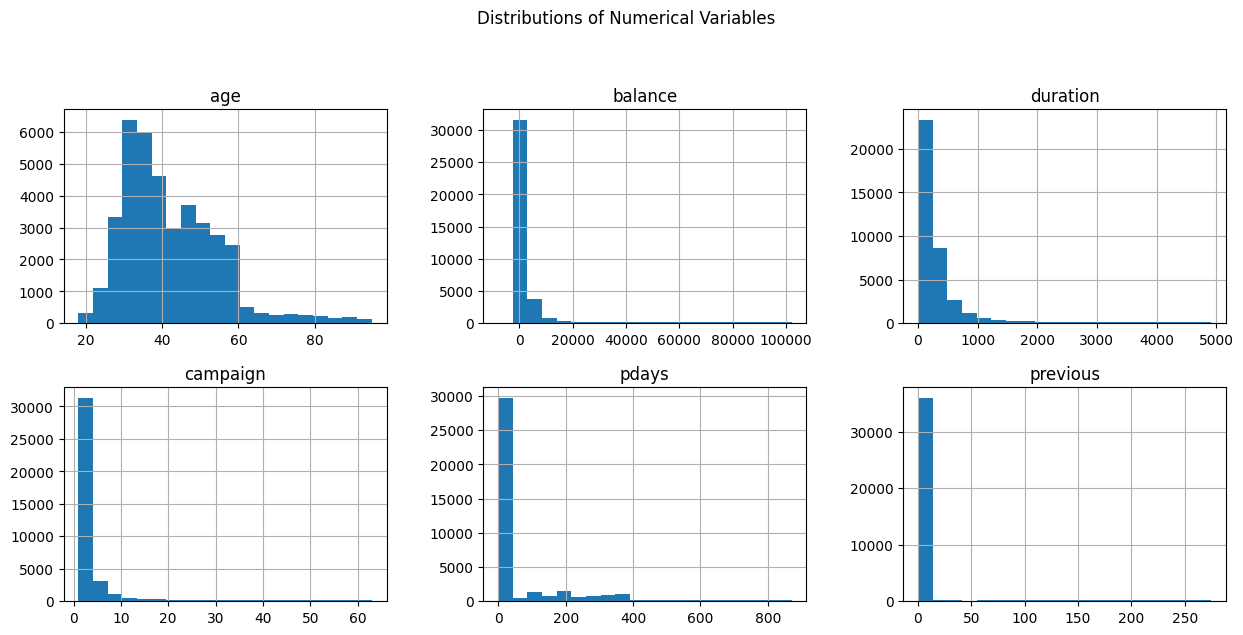

In [939]:
# For numerical features using Histograms
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
train_data[numerical_features].hist(bins=20, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Distributions of Numerical Variables')
plt.show()

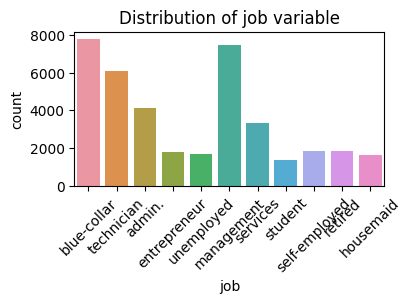

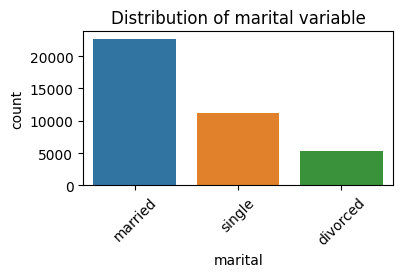

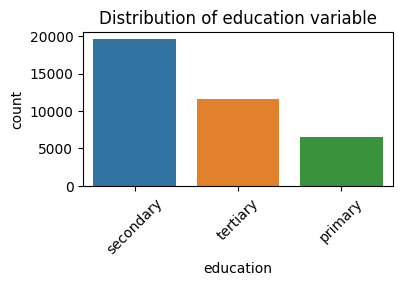

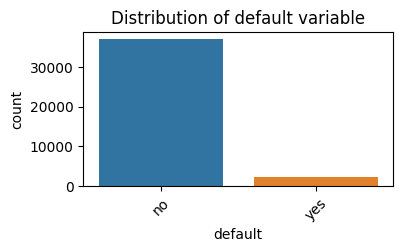

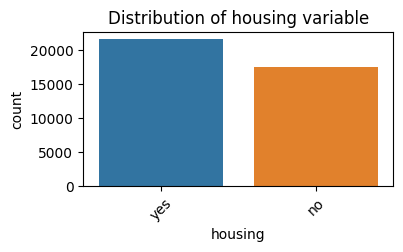

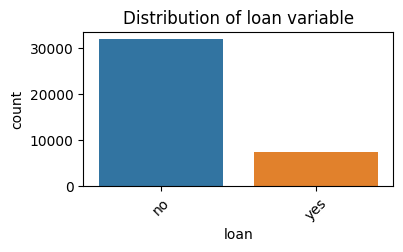

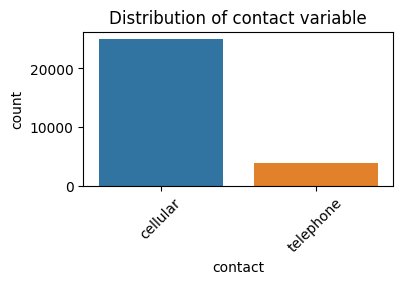

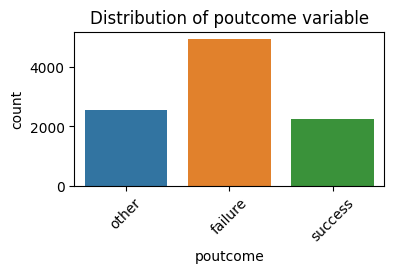

In [940]:
# For categorical features using Bar Charts
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
for col in categorical_features:
    plt.figure(figsize=(4, 2))
    sns.countplot(data=train_data, x=col)
    plt.title(f'Distribution of {col} variable')
    plt.xticks(rotation=45)
    plt.show()

### Bivariate Analysis

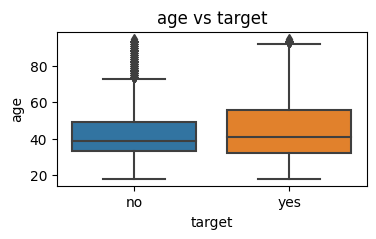

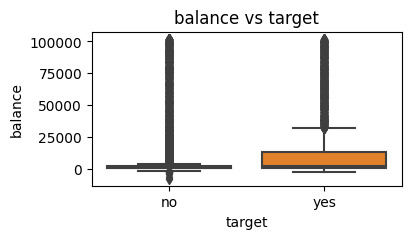

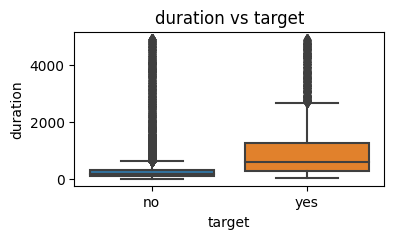

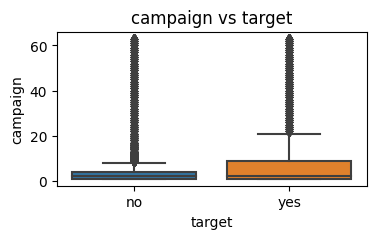

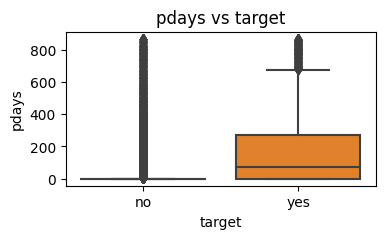

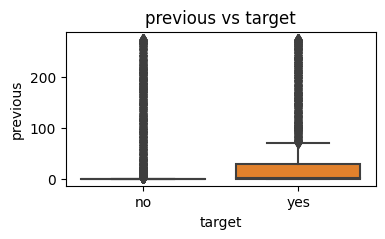

In [941]:
#Numerical features vs target variable using Box plot
for col in numerical_features:
    plt.figure(figsize=(4, 2))
    sns.boxplot(x='target', y=col, data=train_data)
    plt.title(f'{col} vs target')
    plt.show()

##### NOTE:Above Box plots suggest outliers in balance, duration, campaign and pdays. Previous has a lot of values as 0 so determining outliers is difficult.

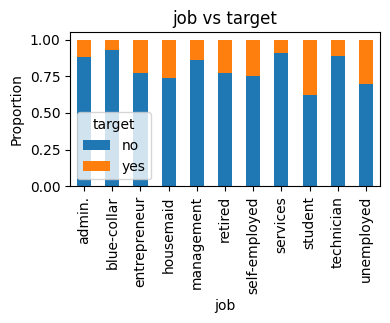

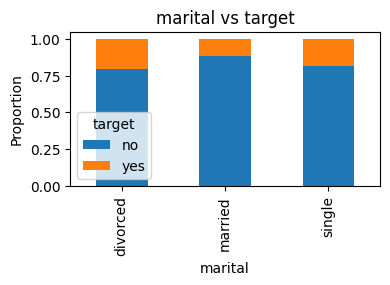

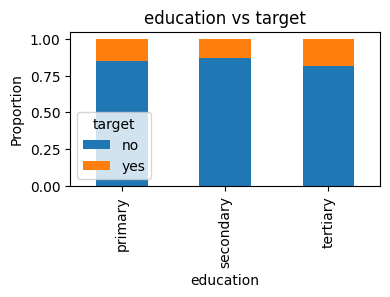

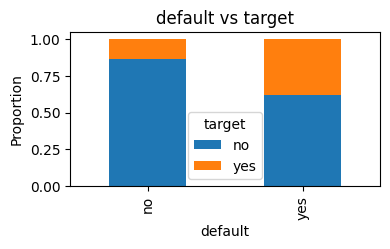

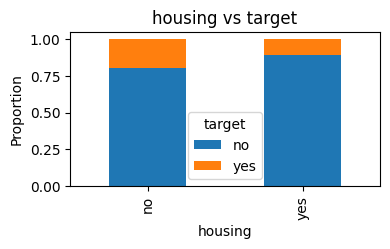

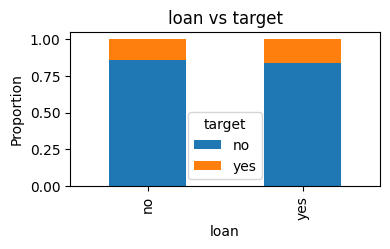

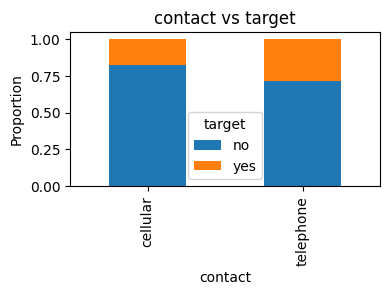

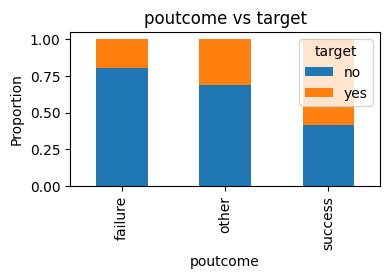

In [942]:
#Categorical features vs target variable using Stacked Bar Charts
for col in categorical_features:
    crosstab = pd.crosstab(train_data[col], train_data['target'], normalize='index')
    crosstab.plot(kind='bar', stacked=True, figsize=(4, 2))
    plt.title(f'{col} vs target')
    plt.ylabel('Proportion')
    plt.show()

##### NOTE: Above stacked bar charts suggest there is a class imbalance. Values of NO are much higher than YES

## Part B: Statistical Analysis

In [943]:
# For numeric features
train_data.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


In [944]:
#For categorical features
train_data[categorical_features].value_counts()

job            marital   education  default  housing  loan  contact    poutcome
blue-collar    married   secondary  no       yes      no    cellular   failure     231
management     married   tertiary   no       yes      no    cellular   failure     193
blue-collar    married   primary    no       yes      no    cellular   failure     156
technician     married   secondary  no       yes      no    cellular   failure     146
management     single    tertiary   no       yes      no    cellular   failure     135
                                                                                  ... 
housemaid      married   primary    yes      yes      no    cellular   other         1
                                             no       no    telephone  other         1
                                    no       yes      yes   telephone  success       1
student        divorced  tertiary   yes      no       no    telephone  failure       1
self-employed  divorced  secondary  yes      no   

In [945]:
#For numerical features: t-test 
# Null Hypothesis-mean values of the feature are the same for two groups in the target variable-YEs and No
for col in numerical_features:
    yes_series = train_data[train_data['target'] == 'yes'][col]
    no_series = train_data[train_data['target'] == 'no'][col]
    t_stat, p_val = stats.ttest_ind(yes_series, no_series)
    print(f'T-test for {col}: t-statistic={t_stat}, p-value={p_val}')

T-test for age: t-statistic=22.305601943418534, p-value=1.569337102271486e-109
T-test for balance: t-statistic=52.8473549385235, p-value=0.0
T-test for duration: t-statistic=72.382314556991, p-value=0.0
T-test for campaign: t-statistic=44.06126474940324, p-value=0.0
T-test for pdays: t-statistic=52.90373433924232, p-value=0.0
T-test for previous: t-statistic=54.00468392048894, p-value=0.0


##### NOTE: p-values<0.05 for all suggesting significant difference in means between the two groups.

In [946]:
# For categorical variables: Chi-square test 
#Null Hypothesis- There is no association between the categorical feature and the target variable.
for col in categorical_features:
    contingency_table = pd.crosstab(train_data[col], train_data['target'])
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table)
    print(f'Chi-square test for {col}: chi2-statistic={chi2_stat}, p-value={p_val}')

Chi-square test for job: chi2-statistic=1951.4012986857706, p-value=0.0
Chi-square test for marital: chi2-statistic=406.3328013977431, p-value=5.8338232683734595e-89
Chi-square test for education: chi2-statistic=181.1418713501203, p-value=4.629588765938241e-40
Chi-square test for default: chi2-statistic=993.5487049897395, p-value=4.534708981631268e-218
Chi-square test for housing: chi2-statistic=654.2622014935782, p-value=2.6434491320142085e-144
Chi-square test for loan: chi2-statistic=18.708260951198042, p-value=1.5232115241364981e-05
Chi-square test for contact: chi2-statistic=256.95334075294306, p-value=7.91826255142232e-58
Chi-square test for poutcome: chi2-statistic=1073.3281715114106, p-value=8.506461106341178e-234


##### NOTE: p-values<0.05, indicating all are significantly associated with the target variable.

In [947]:
# Outlier Treatment
# Replace -1 with NaN temporarily to avoid interference in outlier detection
train_data['pdays'] = train_data['pdays'].replace(-1, np.nan)

# Outlier detection for relevant columns
for col in ['balance', 'duration', 'campaign', 'pdays']:      #Excluding previous from this.
    if col == 'pdays':
        # Exclude NaN values from outlier detection
        Q1 = train_data[col].dropna().quantile(0.25)
        Q3 = train_data[col].dropna().quantile(0.75)
    else:
        Q1 = train_data[col].quantile(0.25)
        Q3 = train_data[col].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outliers- Done capping instead of removing because it is a small dataset and we might have data loss.
    train_data[col] = train_data[col].clip(lower=lower_bound, upper=upper_bound)

# Restore -1 to 'pdays' after outlier handling
train_data['pdays'] = train_data['pdays'].fillna(-1)

In [948]:
train_data.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,1359.241641,282.217209,2.974369,70.568042,11.826171
std,12.709352,1746.748121,235.218816,2.440366,153.708227,44.140259
min,18.000000,-2800.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,4928.000000,786.500000,8.500000,683.500000,275.000000


# STEP 3: Train-Validation Split

In [949]:
X = train_data.drop(columns=['target'])
y = train_data['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 4: Data Cleaning/ Preprocessing

## A. TRAIN/VALIDATION DATA

In [950]:
X_train.isnull().sum()

last contact date        0
age                      0
job                    185
marital                  0
education             1172
default                  0
balance                  0
housing                  0
loan                     0
contact               8267
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             23578
dtype: int64

#### 0. Checking unique values in columns with null values to handle missing values.

In [951]:
X_train['job'].unique()

array(['admin.', 'blue-collar', 'student', 'services', 'entrepreneur',
       'retired', 'housemaid', 'technician', nan, 'self-employed',
       'management', 'unemployed'], dtype=object)

In [952]:
X_train['education'].unique()

array([nan, 'secondary', 'primary', 'tertiary'], dtype=object)

In [953]:
X_train['contact'].unique()

array(['cellular', 'telephone', nan], dtype=object)

In [954]:
X_train['poutcome'].unique()

array([nan, 'success', 'other', 'failure'], dtype=object)

#### 1.Feature Extraction

In [955]:
#Using 'last_contact_date' to get features like day,month and year.

X_train['last contact date'] = pd.to_datetime(X_train['last contact date'], format='%Y-%m-%d')
X_train['contact_year'] = X_train['last contact date'].dt.year
X_train['contact_month'] = X_train['last contact date'].dt.month
X_train['contact_day'] = X_train['last contact date'].dt.day
X_train.drop(columns=['last contact date'], inplace=True)

X_val['last contact date'] = pd.to_datetime(X_val['last contact date'], format='%Y-%m-%d')
X_val['contact_year'] = X_val['last contact date'].dt.year
X_val['contact_month'] = X_val['last contact date'].dt.month
X_val['contact_day'] = X_val['last contact date'].dt.day
X_val.drop(columns=['last contact date'], inplace=True)

In [956]:
#For the column pdays, the value -1 represents clients who were not previously contacted. This can skew the model if treated as a regular numeric value so we can create a
# separate column to tell the model explicitly if the client was contacted or not.

#X_train['was_contacted_before'] = (X_train['pdays'] != -1).astype(int)
#X_val['was_contacted_before'] = (X_val['pdays'] != -1).astype(int)

# After creating this features and runnning the model I observed that the F1 score dropped signifying no use of the feature.
# After removing the feature and replacing -1 in pdays with Nan and imputing it with mean I observed a rise in f1 score suggesting the skewness was reduced.

In [957]:
# has_housing_personal feature- This feature helps capture relation between target and customer with both housing and personal loan
#X_train['has_housing_and_personal'] = ((X_train['housing'] == 'yes') & (X_train['loan'] == 'yes')).astype(int)
#X_val['has_housing_and_personal'] = ((X_val['housing'] == 'yes') & (X_val['loan'] == 'yes')).astype(int)

#### 2. Handling missing values/Nan Values.

In [958]:
# Replace -1 in 'pdays' with NaN since -1 might cause skewness.
X_train['pdays'] = X_train['pdays'].replace(-1, np.nan)
X_val['pdays'] = X_val['pdays'].replace(-1, np.nan)

mode_imputer = SimpleImputer(strategy = 'most_frequent')
constant_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
median_imputer = SimpleImputer(strategy = 'median')

#Filling job, education columns with mode since they have less missing values.
X_train[['job', 'education']] = mode_imputer.fit_transform(X_train[['job', 'education']])
X_val[['job', 'education']] = mode_imputer.transform(X_val[['job', 'education']])

#Filling contact,poutcome columns with 'unknown' since they have more missing values.
X_train[['contact', 'poutcome']] = constant_imputer.fit_transform(X_train[['contact', 'poutcome']])
X_val[['contact', 'poutcome']] = constant_imputer.transform(X_val[['contact', 'poutcome']])

#Filling Nan values in pdays with median.
X_train[['pdays']] = median_imputer.fit_transform(X_train[['pdays']])
X_val[['pdays']] = median_imputer.transform(X_val[['pdays']])

#### 3. Encoding categorical varaibles.

In [959]:
#Using one hot encoding for columns-jobmarital,default,housing,loan,contact,poutcome since they dont have any relation between their values
#Using ordinal encoding on education since it has reltion amongst it values
#Using drop_first=True to avoid multicollinearity

ordinal_encoder = OrdinalEncoder(categories=[['primary', 'secondary', 'tertiary']])

X_train = pd.get_dummies(X_train, columns=['marital', 'default', 'housing', 'loan', 'contact', 'job', 'poutcome'], drop_first=True)
X_train['education'] = ordinal_encoder.fit_transform(X_train[['education']])

X_val = pd.get_dummies(X_val, columns=['marital', 'default', 'housing', 'loan', 'contact','job', 'poutcome'], drop_first=True)
X_val['education'] = ordinal_encoder.transform(X_val[['education']])

#### 4. Scaling Numerical features.

In [960]:
num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
#scaler = StandardScaler()
scaler = RobustScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])

In [961]:
#Converting bool columns to int since after preprocessing most of the columns were boolean
bool_columns = X_train.select_dtypes(include='bool').columns

X_train[bool_columns] = X_train[bool_columns].astype(int)
X_val[bool_columns] = X_val[bool_columns].astype(int)

In [962]:
# Checking if the columns are same in train and val
X_train.columns.equals(X_val.columns)

True

In [963]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31368 entries, 13800 to 15795
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                31368 non-null  float64
 1   education          31368 non-null  float64
 2   balance            31368 non-null  float64
 3   duration           31368 non-null  float64
 4   campaign           31368 non-null  float64
 5   pdays              31368 non-null  float64
 6   previous           31368 non-null  float64
 7   contact_year       31368 non-null  int32  
 8   contact_month      31368 non-null  int32  
 9   contact_day        31368 non-null  int32  
 10  marital_married    31368 non-null  int64  
 11  marital_single     31368 non-null  int64  
 12  default_yes        31368 non-null  int64  
 13  housing_yes        31368 non-null  int64  
 14  loan_yes           31368 non-null  int64  
 15  contact_telephone  31368 non-null  int64  
 16  contact_unknown    3136

### B. TEST DATA

In [964]:
X_test = test_data.copy()

In [965]:
#Feature extraction
X_test['last contact date'] = pd.to_datetime(X_test['last contact date'], format='%Y-%m-%d')
X_test['contact_year'] = X_test['last contact date'].dt.year
X_test['contact_month'] = X_test['last contact date'].dt.month
X_test['contact_day'] = X_test['last contact date'].dt.day
X_test.drop(columns=['last contact date'], inplace=True)

#X_test['has_housing_and_personal'] = ((X_test['housing'] == 'yes') & (X_test['loan'] == 'yes')).astype(int)

#X_test['was_contacted_before'] = (X_test['pdays'] != -1).astype(int)
X_test['pdays'] = X_test['pdays'].replace(-1, np.nan)

# handling missing values on test data
X_test[['job', 'education']] = mode_imputer.transform(X_test[['job', 'education']])
X_test[['contact', 'poutcome']] = constant_imputer.transform(X_test[['contact', 'poutcome']])
X_test[['pdays']] = median_imputer.transform(X_test[['pdays']])

# Encoding 

X_test = pd.get_dummies(X_test, columns=['marital', 'default', 'housing', 'loan', 'contact','job', 'poutcome'], drop_first=True)
X_test['education'] = ordinal_encoder.transform(X_test[['education']])

# Scaling
X_test[num_cols] = scaler.transform(X_test[num_cols])

#Converting bool columns to int
X_test[bool_columns] = X_test[bool_columns].astype(int)

In [966]:
#Checking if Columns in training set are same as that of test set
X_train.columns.equals(X_test.columns)

True

In [967]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10000 non-null  float64
 1   education          10000 non-null  float64
 2   balance            10000 non-null  float64
 3   duration           10000 non-null  float64
 4   campaign           10000 non-null  float64
 5   pdays              10000 non-null  float64
 6   previous           10000 non-null  float64
 7   contact_year       10000 non-null  int32  
 8   contact_month      10000 non-null  int32  
 9   contact_day        10000 non-null  int32  
 10  marital_married    10000 non-null  int64  
 11  marital_single     10000 non-null  int64  
 12  default_yes        10000 non-null  int64  
 13  housing_yes        10000 non-null  int64  
 14  loan_yes           10000 non-null  int64  
 15  contact_telephone  10000 non-null  int64  
 16  contact_unknown    1000

In [968]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7843 entries, 19926 to 27006
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                7843 non-null   float64
 1   education          7843 non-null   float64
 2   balance            7843 non-null   float64
 3   duration           7843 non-null   float64
 4   campaign           7843 non-null   float64
 5   pdays              7843 non-null   float64
 6   previous           7843 non-null   float64
 7   contact_year       7843 non-null   int32  
 8   contact_month      7843 non-null   int32  
 9   contact_day        7843 non-null   int32  
 10  marital_married    7843 non-null   int64  
 11  marital_single     7843 non-null   int64  
 12  default_yes        7843 non-null   int64  
 13  housing_yes        7843 non-null   int64  
 14  loan_yes           7843 non-null   int64  
 15  contact_telephone  7843 non-null   int64  
 16  contact_unknown    7843 

In [969]:
# Drop pdays_not_contacted from X_train,X_val and X_test
#X_train = X_train.drop(columns=['pdays_not_contacted'])
#X_val = X_val.drop(columns=['pdays_not_contacted'])
#X_test = X_test.drop(columns=['pdays_not_contacted'])

# STEP 5: Building models.

## 1. Dummy Model

In [970]:
# Using Dummy classifier for building baseline model

#dummy_classifier = DummyClassifier(strategy='stratified', random_state=42)
#dummy_classifier.fit(X_train, y_train)

## 2. Linear Model

In [971]:
#Logistic Regression with Cross-Validation and Hyper-Parametric tuning

#log_reg = LogisticRegression(random_state=42,class_weight='balanced', max_iter=3000)

#param_grid = {
#    'C': [0.01, 0.1, 1, 10, 100],
#    'solver': ['lbfgs', 'liblinear'],
#    'penalty': ['l2', 'l1']  
#}

# Setting up GridSearchCV with F1 scoring metric

#grid_search = GridSearchCV(log_reg, param_grid, cv=5, n_jobs=-1)
#grid_search.fit(X_train, y_train)

In [972]:
# Getting the best hyperparameters from GSCV

#best_params = grid_search.best_params_
#best_params

In [973]:
# Training the model with the best hyperparameters on the training data

#log_reg_best = LogisticRegression(**best_params,max_iter=3000, random_state=42, class_weight='balanced')
#log_reg_best.fit(X_train, y_train)

## 3. SGD Model

In [974]:
# SGDClassifier with logistic loss to simulate logistic regression

#sgd_clf = SGDClassifier(loss='log_loss', random_state=42, max_iter=1000, class_weight='balanced')

#param_grid = {
#    'alpha': [0.0001, 0.001, 0.01, 0.1],  
#    'penalty': ['l2', 'l1', 'elasticnet'],  
#    'learning_rate': ['constant', 'optimal', 'adaptive'],  
#    'eta0': [0.001, 0.01, 0.1]  
#}

# Setting up GridSearchCV with F1 scoring metric

#grid_search = GridSearchCV(sgd_clf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
#grid_search.fit(X_train, y_train)

In [975]:
# Getting the best hyperparameters from GSCV

#best_params = grid_search.best_params_
#print("Best parameters:", best_params)    

In [976]:
# Training the model with the best parameters on the training data

#sgd_clf_best = SGDClassifier(loss='log_loss', random_state=42, max_iter=1000, class_weight='balanced', **best_params)
#sgd_clf_best.fit(X_train, y_train)

## 4. Naive Bayes Model

In [977]:
#nb_classifier = BernoulliNB()

#param_grid = {
#    'alpha': [0.1, 0.5, 1.0, 2.0],        
#    'binarize': [0.0, 0.5, 1.0, 1.5]      
#}

# Setting up GridSearchCV with F1 scoring metric

#grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
#grid_search.fit(X_train, y_train)

In [978]:
# Getting the best hyperparameters from GSCV

#best_params = grid_search.best_params_
#print("Best parameters for Bernoulli Naive Bayes:", best_params)

In [979]:
# Training the model with the best parameters on the training data

#bernoulli_nb_best = BernoulliNB(**best_params)
#bernoulli_nb_best.fit(X_train, y_train)

## 5. Nearest Neighbor Model

In [980]:
    #knn = KNeighborsClassifier()
    
    #param_grid = {
    #    'n_neighbors': [3, 5, 7, 9, 11],
    #    'weights': ['uniform', 'distance'],
    #    'metric': ['minkowski', 'euclidean', 'manhattan']
    #}
    
    # Setting up GridSearchCV with F1 scoring metric
    
    #grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    #grid_search_knn.fit(X_train, y_train)

In [981]:
# Getting the best hyperparameters from GSCV

#best_params_knn = grid_search_knn.best_params_
#print("Best parameters for KNN:", best_params_knn)

In [982]:
# Training the model with the best parameters on the training data

#knn_best = KNeighborsClassifier(**best_params_knn)
#knn_best.fit(X_train, y_train)

## 6. SVM Model with LDA (Pipelining)

In [983]:
#svm = SVC(class_weight='balanced', random_state=42)

#param_grid = {
#    'C': [0.1, 1, 10, 100],
#    'kernel': ['linear', 'rbf'],
#    'gamma': ['scale', 'auto']  # Gamma only used in rbf kernel
#}

# Setting up GridSearchCV with F1 scoring metric

#grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
#grid_search_svm.fit(X_train, y_train)

In [984]:
# Getting the best hyperparameters from GSCV

#best_params_svm = grid_search_svm.best_params_
#print("Best parameters for SVM:", best_params_svm)

In [985]:
# Training the model with the best parameters on the training data

#svm_best = SVC(**best_params_svm, class_weight='balanced', random_state=42)
#svm_best.fit(X_train, y_train)

# Using LDA

#lda_svm_best_pipeline = Pipeline([
#    ('lda', LinearDiscriminantAnalysis(n_components=1)),  # Dimensionality reduction with LDA
#    ('svm', svm_best)                                      # The best SVM model
#])

# Training the pipeline on the training data

#lda_svm_best_pipeline.fit(X_train, y_train)

## 7. Ensemble Methods

### 7a. BAGGING-Random Forest Classifier

In [986]:
#rf = RandomForestClassifier(random_state=42, class_weight='balanced')

#param_grid_rf = {
#    'n_estimators': [100, 200],               
#    'criterion': ['gini', 'entropy'],              
#    'max_depth': [10, 20, 30]                                                        
#}

# Setting up GridSearchCV with F1 scoring metric

#grid_search_rf = RandomizedSearchCV(rf, param_grid_rf, scoring='f1_macro', cv=5, n_jobs=-1)
#grid_search_rf.fit(X_train, y_train)

In [987]:
# Getting the best hyperparameters from GSCV

#best_params_rf = grid_search_rf.best_params_
#print("Best parameters for Random Forest:", best_params_rf)

In [988]:
# Training the model with the best parameters on the training data

#rf_best = RandomForestClassifier(**best_params_rf)
#rf_best.fit(X_train, y_train)

### 7b. BOOSTING-XGB Classifier

In [989]:
# Encoding y_train and y_val as XGB classifier needs numerical target variables.
label_encoder = LabelEncoder()

# Fit on y_train and transform both y_train and y_val
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

In [990]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4,],
    'scale_pos_weight': [1, 3, 5]  # Adjust class imbalance
}

# Setting up GridSearchCV with F1 scoring metric

grid_search_xgb = RandomizedSearchCV(xgb, param_grid_xgb, scoring='f1_macro', cv=5, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [2, 3, 4],
                                        'n_estimators': [100, 200],
                                        'scale_pos_weight': [1, 3, 5]},
                   scoring='f1_macro')

In [991]:
# Getting the best hyperparameters from GSCV

best_params_xgb = grid_search_xgb.best_params_
print("Best parameters for X Gradient Boost:", best_params_xgb)

Best parameters for X Gradient Boost: {'scale_pos_weight': 3, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1}


In [992]:
# Training the model with the best parameters on the training data

xgb_best = XGBClassifier(**best_params_xgb)
xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [993]:
# Getting feature importance from Random Forest classifier

#importances = xgb_best.feature_importances_
#indices = importances.argsort()

#plt.figure(figsize=(12, 6))
#plt.title("Feature Importance")
#plt.barh(range(len(indices)), importances[indices], align="center")
#plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
#plt.xlabel("Importance")
#plt.show()

In [994]:
# Cross-Validation Scores for the best model
#cv_scores = cross_val_score(xgb_best, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)

#print(f"Cross-Validation F1 Scores (macro): {cv_scores}")
#print(f"Average Cross-Validation F1 Score (macro): {cv_scores.mean()}")

### 7c. BOOSTING-CatBoost Classifier

In [995]:
#categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']      #F1 score-0.719
#catboost_model = CatBoostClassifier(
#    iterations=500,             # Number of boosting iterations
#    learning_rate=0.1,          # Learning rate
#    depth=6,                    # Tree depth
#    cat_features=categorical_features,  # Specify categorical features
#    loss_function='Logloss',    # Use Logloss for binary classification
#    eval_metric='F1',           # Use F1 for evaluation
#    verbose=100                 # Print updates every 100 iterations
#)
#catboost_model.fit(
#    X_train, y_train,
#    eval_set=(X_val, y_val),     # Use validation set for evaluation during training
#    early_stopping_rounds=50     # Stop if no improvement for 50 iterations
#)

### MLP Classifier

In [996]:
#mlp = MLPClassifier(max_iter=500, random_state=42)

#param_grid_mlp = {
#    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100, 50)],
#    'activation': ['relu', 'tanh'],
#    'solver': ['adam', 'sgd'],
#    'alpha': [0.0001, 0.001, 0.01],
#    'learning_rate': ['constant', 'adaptive']
#}

# Setting up GridSearchCV with F1 scoring metric

#ran_search_mlp = RandomizedSearchCV(mlp, param_grid_mlp, scoring='f1_macro', cv=3, n_jobs=-1)
#ran_search_mlp.fit(X_train, y_train)

In [997]:
# Getting the best hyperparameters from GSCV

#best_params_mlp = ran_search_mlp.best_params_
#print("Best parameters for MLP:", best_params_mlp)

In [998]:
# Training the model with the best parameters on the training data

#mlp_best = MLPClassifier(**best_params_mlp)
#mlp_best.fit(X_train, y_train)

## STACKING

In [999]:
# Define base learners with the pre-trained models
#base_learners = [
#    ('lr', log_reg_best),       # Pre-trained Logistic Regression
#    ('rf', rf_best),             # Pre-trained Random Forest
#    ('xgb', xgb_best)                   # Pre-trained XGBoost
#]

# Define the meta-model
#meta_learner = LogisticRegression()

# Define the stacking classifier
#stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Train the stacking model on the training set
#stacking_model.fit(X_train, y_train)

## Evaluation of model

In [1000]:
# Evaluating the tuned model on the validation set

#y_val_pred_dc = dummy_classifier.predict(X_val)
#y_val_pred_lr = log_reg_best.predict(X_val)
#y_val_pred_sgd = sgd_clf_best.predict(X_val)
#y_val_pred = nb_classifier.predict(X_val)
#y_val_pred_nb = bernoulli_nb_best.predict(X_val)
#y_val_pred_knn = knn_best.predict(X_val)
#y_val_pred_svm = svm_best.predict(X_val)
#y_val_pred_lda_svm = lda_svm_best_pipeline.predict(X_val)
#y_val_pred_rf = rf_best.predict(X_val)
y_val_pred = xgb_best.predict(X_val)
#y_val_pred = catboost_model.predict(X_val)
#y_val_pred = mlp_best.predict(X_val)
#y_val_pred = stacking_model.predict(X_val)

# Calculating F1 score (macro) for validation set
f1_score_macro = f1_score(y_val, y_val_pred, average='macro')
print("F1 Score (macro) on validation set:", f1_score_macro)

F1 Score (macro) on validation set: 0.7796422779228595


In [1001]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.96      0.87      0.92      6645
           1       0.53      0.81      0.64      1198

    accuracy                           0.86      7843
   macro avg       0.75      0.84      0.78      7843
weighted avg       0.90      0.86      0.87      7843



## Predictions on Test Data

In [1002]:
# Making Predictions

#y_test_pred = dummy_classifier.predict(X_test)
#y_test_pred = log_reg_best.predict(X_test)
#y_test_pred = sgd_clf_best.predict(X_test)
#y_test_pred = bernoulli_nb_best.predict(X_test)
#y_test_pred = knn_best.predict(X_test)
#y_test_pred = svm_best.predict(X_test)
#y_test_pred = lda_svm_best_pipeline.predict(X_test)
#y_test_pred = rf_best.predict(X_test)
y_test_pred = xgb_best.predict(X_test)
#y_test_pred = catboost_model.predict(X_test)
#y_test_pred = mlp_best.predict(X_test)
#y_test_pred = stacking_model.predict(X_test)

#The output from xgb classifier is given in numerical format so converting it back to categorical format using inverse_transform.
y_test_pred=label_encoder.inverse_transform(y_test_pred)
y_test_pred

array(['no', 'no', 'no', ..., 'no', 'yes', 'no'], dtype=object)

# STEP 6: Creating Submission File

In [1003]:
submission = pd.DataFrame({
    'id': range(len(test_data)),
    'target': y_test_pred
})

# Save the submission file
submission.to_csv('/kaggle/working/submission.csv', index=False)